# Parameter sweeps

This notebook will cover:
* How to change dimensional and non-dimensional parameter values
* How to assign new parameter sets to existing models
* How to carry out parameter sweeps and compute stress-strain curves

## Motivation

Is it common to use modelling to predict the response of a material over a wide range of parameters.  In `ucompress.py`, models consist of symbolic (mathematically exact) expressions.  Parameter objects with specific parameter values are then substituted into these symbolic expressions and converted into NumPy functions.  The NumPy functions are then called when simulating the model.  Carrying out a parameter sweep requires updating the parameter object, potentially non-dimensionalising the parameters again, and then re-substituting the updated parameter set into the symbolic model.  This pipeline avoids the need to re-build the symbolic model, which can be time consuming depending on the complexity of the model.

## Example 1 - Computing a stress-strain curve

In this example, we will plot a stress-strain curve for a neo-Hookean material.  We first load a parameter set and the mechanics model

In [1]:
import ucompress as uc
import matplotlib.pyplot as plt
import numpy as np

pars = uc.parameters.example_parameters.NeoHookean(nondim = False)
mech = uc.mechanics.NeoHookean()

The `mech` variable is an object that contains the symbolic expressions for the elastic stresses.  We can convert these expressions into NumPy functions using the `lambdify` method and passing the corresponding parameter values

In [4]:
mech.lambdify(pars)

Now the elastic stresses can be evaluated as follows:

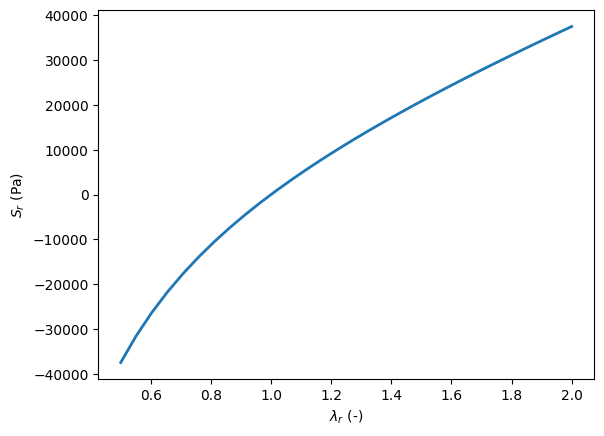

In [6]:
# define the principal stretches (radial, circumferential, axial) assuming incompressibility
lambda_r = np.linspace(0.5, 2, 30)
lambda_t = lambda_r
lambda_z = 1 / lambda_r**2

# evaluate the principal stresses
S_r, S_t, S_z = mech.eval_stress(lambda_r, lambda_t, lambda_z)

# Plot
plt.plot(lambda_r, S_r, lw = 2)
plt.xlabel(r'$\lambda_r$ (-)')
plt.ylabel(r'$S_r$ (Pa)')
plt.show()

## Example 2 - Impact of the Poisson's ratio

We will now compute the stress-strain curve for a range of Poisson's ratios.  This will require updating the value of $\nu_m$ in the parameter object.  These updates are possible using the `update` method:

In [18]:
for nu_m in [0, 0.25, 0.49]:
    pars.update('nu_m', nu_m)
    print('nu_m =', pars.physical['nu_m'])

nu_m = 0
nu_m = 0.25
nu_m = 0.49


Using the `update` function is the preferred method to update entries in the parameter structure.  This will ensure that any non-dimensional quantities are updated, as we'll see below.

Using this approach, it is straightforward to calculate the stress-strain curve across the different values of $\nu_m$:

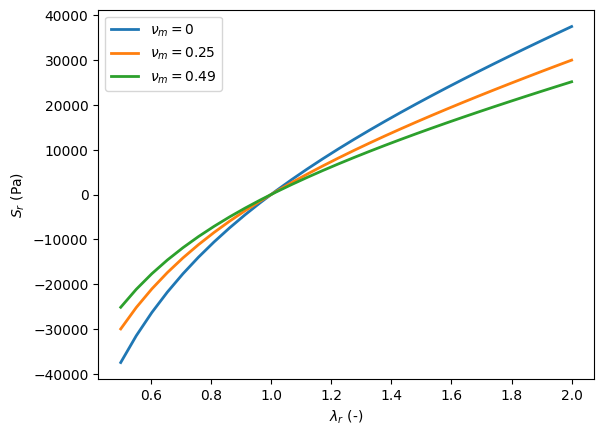

In [19]:
for nu_m in [0, 0.25, 0.49]:
    pars.update('nu_m', nu_m)
    mech.lambdify(pars)
    S_r, S_t, S_z = mech.eval_stress(lambda_r, lambda_t, lambda_z)

    plt.plot(lambda_r, S_r, lw = 2, label = f'$\\nu_m = {nu_m}$')

plt.xlabel(r'$\lambda_r$ (-)')
plt.ylabel(r'$S_r$ (Pa)')
plt.legend()
plt.show()

## Example 3 - Assigning parameter sets to models

In this example, we will look at how the Young's modulus of the neo-Hookean matrix impacts the time-dependent response of a sample under displacement-controlled loading.  The parameters will be non-dimensionalised before simulating the model.

In [28]:
# Define the parts of the model
pars = uc.parameters.example_parameters.NeoHookean(nondim = True)
mech = uc.mechanics.NeoHookean()
perm = uc.permeability.Constant()

We now build the model.  This process automatically triggers the conversion of the symbolic expressions into NumPy functions through the substitution of the parameter object

In [29]:
model = uc.base_models.Poroelastic(mech, perm, pars)

A for loop is now used to solve the problem across three values of the Young's modulus.  To update the parameter set, the **dimensional** value of the Young's modulus is passed to the `update` method; the non-dimensionalisation of the new parameter set happens behind the scenes.  Afterwards, the `assign` method is used to substitute the updated parameter values into the model and update all of the NumPy functions:

--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.1
--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.1
--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.1


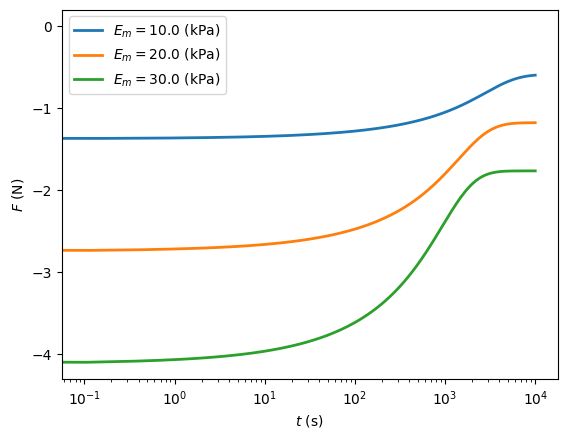

In [34]:
# loop over Young's modulus values (dimensional values)
for E_m in [1e4, 2e4, 3e4]:

    # update parameter set with new dimensional values
    pars.update('E_m', E_m)

    # assign updated parameters to the model
    model.assign(pars)

    # create an experiment and solve
    problem = uc.experiments.DisplacementControlled(model, pars)
    sol = problem.transient_response()

    # re-dimensionalise the solution
    sol.redimensionalise(pars)
    
    # plot
    plt.semilogx(sol.t, sol.F, lw = 2, label = f'$E_m = {E_m/1e3}$ (kPa)')

plt.xlabel('$t$ (s)')
plt.ylabel('$F$ (N)')
plt.legend()
plt.show()